## Measurement uncertainties and relativistic factors in jet motion in 4U 1543$-$47

In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as const
import scipy.stats as st
from scipy.stats import rv_continuous
import edr3funcs
import cmasher as cms
import matplotlib.pyplot as plt
plt.rc('font', family='serif')

def truncnorm(mu, sd, a, b):
    """
    Reparametrizing the Scipy definition for convenience
    
    """
    return st.truncnorm((a-mu)/sd, (b-mu)/sd, loc=mu, scale=sd)

## Assumptions and input

- Distance ($d$): Parrallax from Gaia EDR3, with Zero-point correction from [Lindegren et al. 2020](https://arxiv.org/abs/2012.01742), and method from [Atri et al. 2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.489.3116A/abstract) to derive a PDF for $p(d)$. 
- Proper motion ($\mu$): Assuming a normal distribution based on reported value and uncertainty, $\mathcal{N}(\mu,\sigma_\mu)$
- Inclination ($i$): For inclination two sets of assumptions are used
    - "Narrow" set: Normal distribution based on the reported constraints on $i$, $\mathcal{N}(i_{obs},\sigma_i)$.
    - "Wide" set: Assuming a very broad and weakly informed distribution in form of a broad normal in $\cos(i)\sim\mathcal{N}(\cos(i_{obs}),0.1)$.


In [2]:
N = 1000000 # sample size

# PDFs and Generating random samples
mu = st.norm(120,19).rvs(N) * u.mas/u.day
i = st.norm(20.7,1.5).rvs(N) * u.deg
i_broad = np.rad2deg(np.arccos(truncnorm(np.cos(20*u.deg),0.1,0,1).rvs(N))) * u.deg


## For distance PDF estiamte and sampling is based on Atri et al. 2019
_, atri_distance_pdf_func, distance_array = edr3funcs.atri_dist(parallax=0.2237830974986263, 
                                                                parallax_er=0.0550747849047184,
                                                                ra=236.78443716387173, 
                                                                dec=-47.66954730252564)

class atri_distance_distrib(rv_continuous):
    def _pdf(self, x):
        return atri_distance_pdf_func(x)

# Generating the distance sample takes substantially long,
# sampling from a custom numerical function is computationally taxing,
# thus a sample is already made and saved in file for quick runs

generate_d_sample = False

if generate_d_sample:
    d = atri_distance_distrib(a=0.01,b=40).rvs(size=N) * u.kpc
    np.savetxt('random_samp_d.txt',d.value)
else:
    d = np.loadtxt('https://www.dropbox.com/s/3t5g3sjinz11hsm/random_samp_d.txt?dl=1') * u.kpc


## Calculating $\beta$ and $\gamma$ for the generated samples

In [3]:
def relativity_factors(mu, d, i):
    """
    beta and gamma calculator
    also cleans the input arrays from values that return beta > 1 
    
    """
    c = const.c
    beta = (mu * d / c / (np.sin(i)*u.rad + (np.cos(i)*mu*d/c))).decompose()
    
    mu = mu[beta < 1]
    d = d[beta < 1]
    i = i[beta < 1]
    beta = beta[beta < 1]
    gamma = 1/np.sqrt(1-beta**2)

    return mu, d, i, beta, gamma


mu_narrow, d_narrow, i_narrow, beta_narrow, gamma_narrow = relativity_factors(mu, d, i)
mu_wide, d_wide, i_wide, beta_wide, gamma_wide = relativity_factors(mu, d, i_broad)

## Plotting the PDFs

In [4]:
def prob_plotter(y_array, x_array, x_array2, x_array3, label):
    fig = plt.figure(figsize=(20,6))
    ax_marginal_y = plt.subplot2grid((4,12),(0,0),rowspan=3,colspan=1)
    ax_marginal_y.hist(y_array,bins=50,alpha=0.9,edgecolor='w',density=True,orientation='horizontal',color=cms.freeze_r.colors[128])
    ax_marginal_y.set_xlabel(r'$p('+label+r')$',fontsize=16)
    ax_marginal_y.set_ylabel(r'$'+label+r'$',fontsize=16)
    ax_marginal_y.set_ylim(y_array.min(),y_array.max())
    ax_marginal_y.set_xlim(0)
    ax_marginal_y.minorticks_on()
    ax_marginal_y.tick_params(axis='both', which='major', labelsize=12, length=5)
    ax_marginal_y.tick_params(axis='both', which='minor', length=2.5)
    ax_marginal_y.tick_params(axis='both', which='both', direction='in',right=True,top=True)
    
    ax_marginal_x = plt.subplot2grid((4,12),(3,1),rowspan=1,colspan=3)
    ax_marginal_x.hist(x_array,bins=50,alpha=0.9,edgecolor='w',density=True,color=cms.freeze_r.colors[128])
    ax_marginal_x.set_ylabel(r'$p(i)$',fontsize=16)
    ax_marginal_x.set_xlabel(r'$i (^\circ)$',fontsize=16)
    ax_marginal_x.set_xlim(x_array.min(),x_array.max())
    ax_marginal_x.set_ylim(0)
    ax_marginal_x.minorticks_on()
    ax_marginal_x.tick_params(axis='both', which='major', labelsize=12, length=5)
    ax_marginal_x.tick_params(axis='both', which='minor', length=2.5)
    ax_marginal_x.tick_params(axis='both', which='both', direction='in',right=True,top=True)

    ax_marginal_x2 = plt.subplot2grid((4,12),(3,5),rowspan=1,colspan=3)
    ax_marginal_x2.hist(x_array2,bins=50,alpha=0.9,edgecolor='w',density=True,color=cms.freeze_r.colors[128])
    ax_marginal_x2.set_ylabel(r'$p(d)$',fontsize=16)
    ax_marginal_x2.set_xlabel(r'$d$ (kpc)',fontsize=16)
    ax_marginal_x2.set_xlim(x_array2.min(),x_array2.max())
    ax_marginal_x2.set_ylim(0)
    ax_marginal_x2.minorticks_on()
    ax_marginal_x2.tick_params(axis='both', which='major', labelsize=12, length=5)
    ax_marginal_x2.tick_params(axis='both', which='minor', length=2.5)
    ax_marginal_x2.tick_params(axis='both', which='both', direction='in',right=True,top=True)

    ax_marginal_x3 = plt.subplot2grid((4,12),(3,9),rowspan=1,colspan=3)
    ax_marginal_x3.hist(x_array3,bins=50,alpha=0.9,edgecolor='w',density=True,color=cms.freeze_r.colors[128])
    ax_marginal_x3.set_ylabel(r'$p(\mu)$',fontsize=16)
    ax_marginal_x3.set_xlabel(r'$\mu$ (arcsec d$^{-1}$)',fontsize=16)
    ax_marginal_x3.set_xlim(x_array3.min(),x_array3.max())
    ax_marginal_x3.set_ylim(0)
    ax_marginal_x3.minorticks_on()
    ax_marginal_x3.tick_params(axis='both', which='major', labelsize=12, length=5)
    ax_marginal_x3.tick_params(axis='both', which='minor', length=2.5)
    ax_marginal_x3.tick_params(axis='both', which='both', direction='in',right=True,top=True)

    ax_joint = plt.subplot2grid((4,12),(0,1),rowspan=3,colspan=3)
    xyjoint = ax_joint.hist2d(x_array, y_array,cmap=cms.freeze_r,bins=200,density=True)[3]
    ax_joint.set_xlim(x_array.min(),x_array.max())
    ax_joint.set_ylim(y_array.min(),y_array.max())
    ax_joint.set_xticklabels([])
    ax_joint.set_yticklabels([])
    ax_joint.tick_params(axis='both', which='both', direction='in',right=True,top=True)
    cbarax = fig.add_axes([0.378, 0.32, 0.01, 0.56])
    plt.colorbar(xyjoint,cax=cbarax)
    cbarax.set_ylabel(r'$p(i,'+label+r')$',fontsize=16)

    ax_joint2 = plt.subplot2grid((4,12),(0,5),rowspan=3,colspan=3)
    xyjoint2 = ax_joint2.hist2d(x_array2, y_array,cmap=cms.freeze_r,bins=200,density=True)[3]
    ax_joint2.set_xlim(x_array2.min(),x_array2.max())
    ax_joint2.set_ylim(y_array.min(),y_array.max())
    ax_joint2.set_xticklabels([])
    ax_joint2.set_yticklabels([])
    ax_joint2.tick_params(axis='both', which='both', direction='in',right=True,top=True)
    cbarax2 = fig.add_axes([0.64, 0.32, 0.01, 0.56])
    plt.colorbar(xyjoint2,cax=cbarax2)
    cbarax2.set_ylabel(r'$p(d,'+label+r')$',fontsize=16)

    ax_joint3 = plt.subplot2grid((4,12),(0,9),rowspan=3,colspan=3)
    xyjoint3 = ax_joint3.hist2d(x_array3, y_array,cmap=cms.freeze_r,bins=200,density=True)[3]
    ax_joint3.set_xlim(x_array3.min(),x_array3.max())
    ax_joint3.set_ylim(y_array.min(),y_array.max())
    ax_joint3.set_xticklabels([])
    ax_joint3.set_yticklabels([])
    ax_joint3.tick_params(axis='both', which='both', direction='in',right=True,top=True)
    cbarax3 = fig.add_axes([0.902, 0.32, 0.01, 0.56])
    plt.colorbar(xyjoint3,cax=cbarax3)
    cbarax3.set_ylabel(r'$p(\mu,'+label+r')$',fontsize=16)
    
    return fig


def filtering_for_plots(mu, d, i, beta, gamma):
    """
    Given the probablistic nature of these dsitributions,
    There are rare realizations with beta < 0.85 or Gamma > 15
    While we will include these in point and interval estimation
    we ignore them for plotting for aeasthetics
    
    This function trims those values and returns np arrays with no units

    """
    select = (gamma < 15) & (beta > 0.85)
    mu = mu[select]
    d = d[select]
    i = i[select]
    beta = beta[select]
    gamma = gamma[select]
    return mu.value, d.value, i.value, beta.value, gamma.value

plt_mu_wide, plt_d_wide, plt_i_wide, plt_beta_wide, plt_gamma_wide = filtering_for_plots(mu_wide, d_wide, i_wide, beta_wide, gamma_wide)
plt_mu_narrow, plt_d_narrow, plt_i_narrow, plt_beta_narrow, plt_gamma_narrow = filtering_for_plots(mu_narrow, d_narrow, i_narrow, beta_narrow, gamma_narrow)

### $\beta$ Joint PDFs assuming the **narrow** inclination PDF

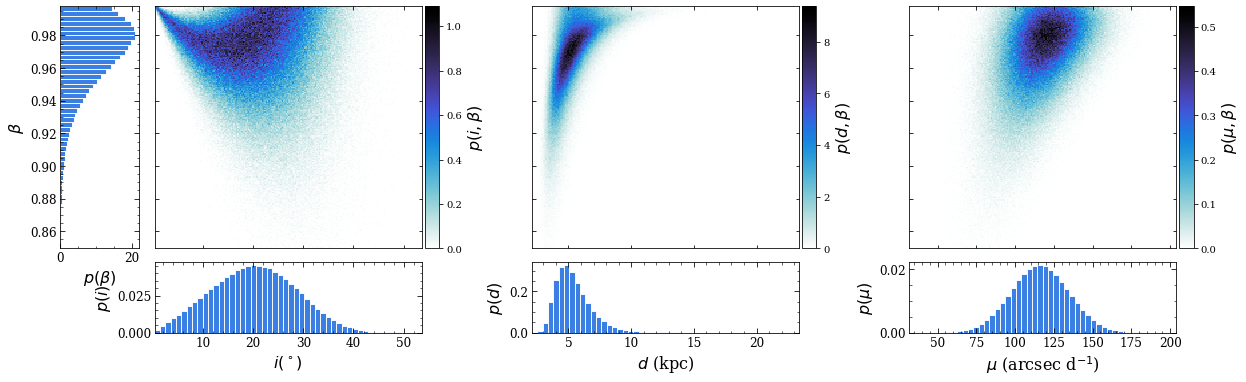

In [5]:
beta_fig_wide = prob_plotter(plt_beta_wide, plt_i_wide, plt_d_wide, plt_mu_wide, r'\beta');
beta_fig_wide.savefig('1543_beta_wide.jpg',bbox_inches='tight',dpi=300)

### $\beta$ Joint PDFs assuming the **wide** inclination PDF

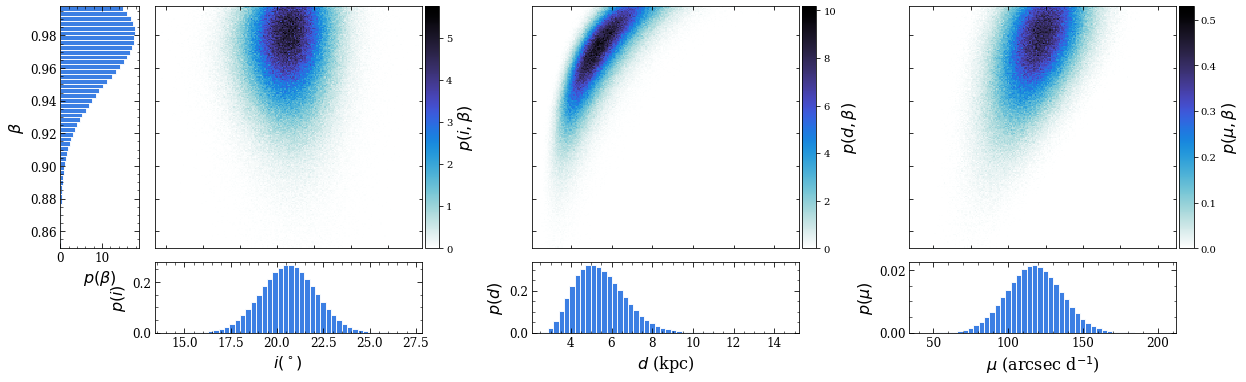

In [6]:
beta_fig_narrow = prob_plotter(plt_beta_narrow, plt_i_narrow, plt_d_narrow, plt_mu_narrow, r'\beta');
beta_fig_narrow.savefig('1543_beta_narrow.jpg',bbox_inches='tight',dpi=300)

### $\gamma$ Joint PDFs assuming the **narrow** inclination PDF

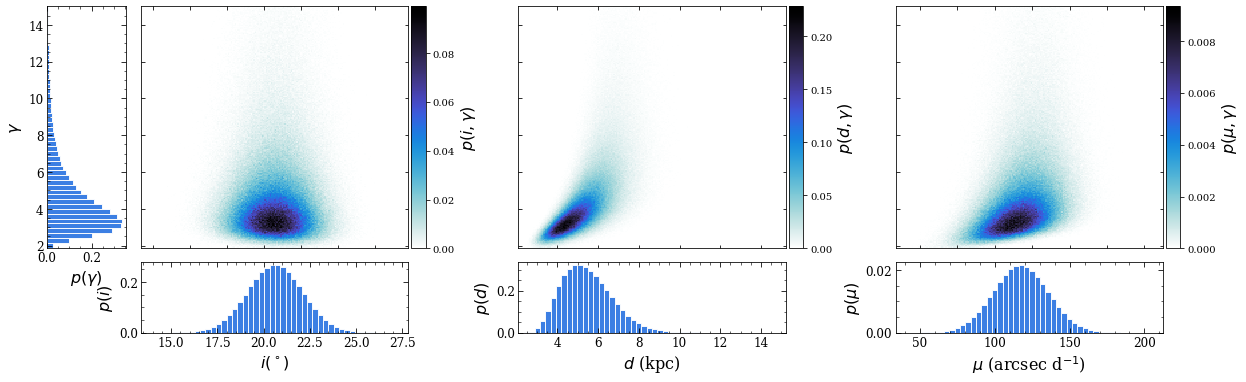

In [7]:
gamma_fig_wide = prob_plotter(plt_gamma_narrow, plt_i_narrow, plt_d_narrow, plt_mu_narrow, r'\gamma');
gamma_fig_wide.savefig('1543_gamma_wide.jpg',bbox_inches='tight',dpi=300)

### $\gamma$ Joint PDFs assuming the **wide** inclination PDF

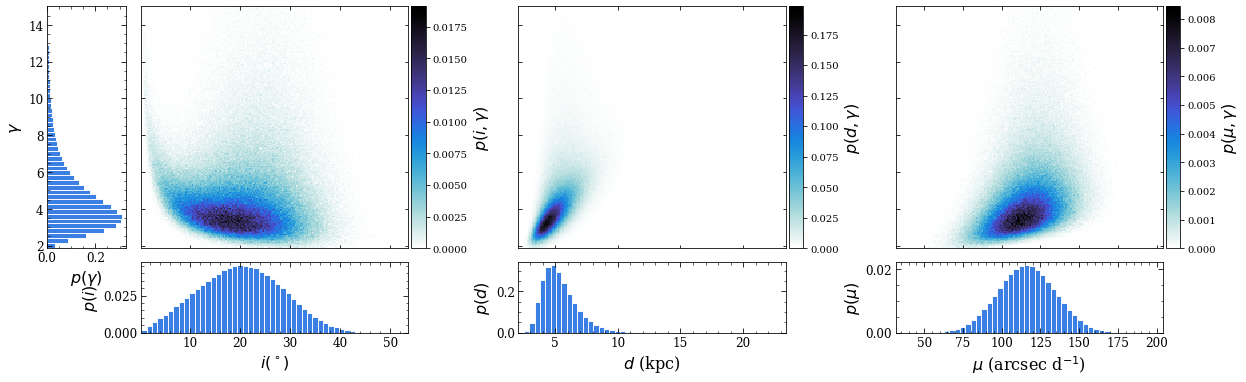

In [8]:
gamma_fig_narrow = prob_plotter(plt_gamma_wide, plt_i_wide, plt_d_wide, plt_mu_wide, r'\gamma');
gamma_fig_narrow.savefig('1543_gamma_narrow.jpg',bbox_inches='tight',dpi=300)

## Point and interval estimation for $\gamma$

In [9]:
def gamma_pie(array, plt_array):
    median = np.median(array)
    p05 = np.quantile(array, 0.05)
    p95 = np.quantile(array, 0.95)
    
    # Mode estimatation based on the plt_array
    dist_kde_func = st.gaussian_kde(plt_array,bw_method='silverman')
    kde_func_x = np.linspace(plt_array.min(),plt_array.max(),1000)
    kde_func_y = dist_kde_func(kde_func_x)
    mode = kde_func_x[kde_func_y.argmax()]
    
    #print(f'Median\t{median}')
    #print(f'Mode\t{mode}')
    #print(f'5%\t{p05}')
    #print(f'95%\t{p95}')
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.hist(plt_array,bins=100,density=True,color='b',alpha=0.7,histtype='step')
    ax.axvline(median,linestyle='-',color='r',label=f'Median: {median:2.3f}')
    ax.axvline(mode,linestyle='-',color='k',label=f'Mode: {mode:2.3f}')
    ax.axvline(p05,linestyle=':',color='r',label=f'5%: {p05:2.3f}')
    ax.axvline(p95,linestyle=':',color='r',label=f'95%: {p95:2.3f}')
    #ax.plot(kde_func_x,kde_func_y,'--r')
    ax.legend(loc=1,fontsize=12)
    ax.set_xlabel(r'$\gamma$',fontsize=16)
    ax.set_xlim(plt_array.min(),plt_array.max())
    ax.tick_params(axis='both', which='major', labelsize=12, length=5)
    ax.tick_params(axis='both', which='minor', length=2.5)
    ax.tick_params(axis='both', which='both', direction='in',right=True,top=True)

    return fig

### $\gamma$ with the **narrow** inclination PDF

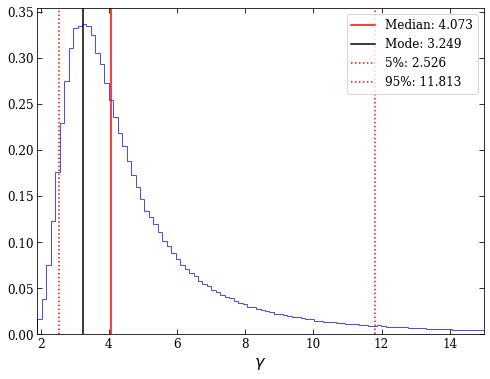

In [10]:
gamma_pie(gamma_narrow.value,plt_gamma_narrow);

### $\gamma$ with the **wide** inclination PDF

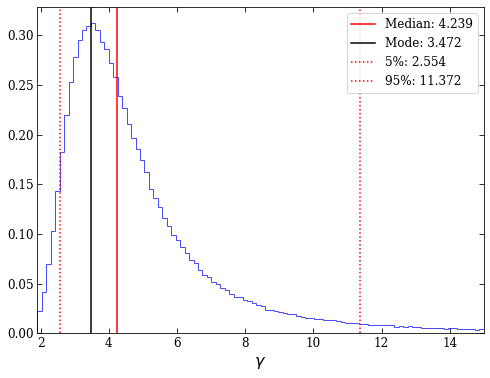

In [11]:
gamma_pie(gamma_wide.value,plt_gamma_wide);